# Calculation of $G_\mathrm{ep}$ and heat capacities from DFT results (not spin resolved)

This notebook calculates the electron-phonon coupling parameter $G_\mathrm{ep}$ and the electron and phonon heat capacity from DFT results (electronic density of states, phonon density of states, Fermi level, Eliashberg function). 

Note that this is the version for a non-spin-resolved DFT calculation. Use the notebook main_spin_resolved for a spin-resolved DFT calculation (e.g. for ferromagnetic materials).


## Load required modules, settings from config file, DFT results and other material parameters

In order to perform the calculation for another material, create a .py file named material+'_spin_resolved' in the folder 'load_inputs' that loads all necessary material-specific data (see examples). Furthermore, change the material entry in the file confic.cfg.

In [1]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt


# import functions saved separately
from functions.chemical_potential import calculate_chemical_potential
from functions.electron_phonon_coupling import calculate_electron_phonon_coupling
from functions.electron_heat_capacity import calculate_electron_heat_capacity
from functions.phonon_heat_capacity import calculate_phonon_heat_capacity

# import settings from config file
import configparser
config = configparser.ConfigParser()
config.read('config.cfg')
# material (string), to load the corresponding material-specific data and to save the results in the right text file:
material=config['GENERAL']['Material']
# lattice temperature in K, for the calculation of the electron-phonon coupling parameter G:
lattice_temperature=float(config['GENERAL']['Lattice_temperature'])
# desired temperature range in which all quantities should be calculated, in K:
temperatures = np.linspace(int(config['TEMPERATURE']['Temperature_min']),\
                          int(config['TEMPERATURE']['Temperature_max']),\
                           int(config['TEMPERATURE']['Temperature_points']))


# run the script that imports all required material-specific data (DFT calculation results and unit cell volume)
input_script_name='load_inputs/'+material+'_not_spin_resolved'
%run $input_script_name

Material-specific data for nickel has been loaded.


## Chemical potential
The chemical potential is required for calculating the electron-phonon coupling and the electronic heat capacity.
 The chemical potential ($\mu$) is temperature-dependent because the number of electrons per unit cell ($N_\mathrm{e}$) is constant:
 
$ 
N_\mathrm{e}=\int_{-\infty}^{\infty} g_\mathrm{e}(\epsilon) \frac{1}{\mathrm{exp}\left( \frac{\epsilon-\mu}{k_\mathrm{B}T}\right)+1}d\epsilon=\int_{-\infty}^{\epsilon_\mathrm{F}} g_\mathrm{e}(\epsilon) d\epsilon.
$

Here $g_\mathrm{e}$ is the electronic density of states, $T$ is the temperature, $\epsilon_\mathrm{F}$ is the Fermi energy and $\epsilon$ denotes the energy.

Using this equation, the chemical potential as a function of temperature is calculated numerically.

<IPython.core.display.Javascript object>


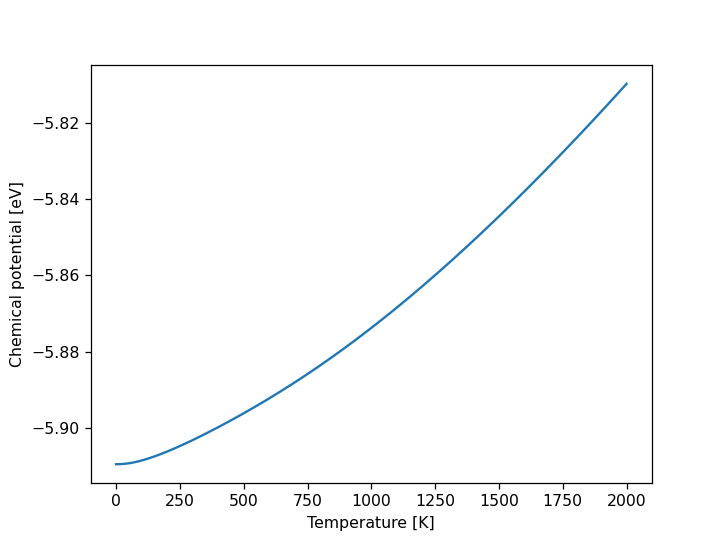

In [2]:
mu = calculate_chemical_potential(temperatures,e_dos,fermi_energy)

# plot the result (optional)
plt.figure()
plt.plot(temperatures,mu)
plt.xlabel('Temperature [K]'), plt.ylabel('Chemical potential [eV]');

## Electron-phonon coupling parameter ($G_\mathrm{ep}$)

The electron-phonon coupling parameter is calculated as in Waldecker et al., Phys. Rev. X 6, 021003 (https://doi.org/10.1103/PhysRevX.6.021003), Equation 9, with the (small) difference that changes of the chemical potential with electron temperature are considered here. The corresponding equations are:

$Z(T_\mathrm{e},T_\mathrm{l})=-\frac{2\pi}{g_\mathrm{e}(\mu)}\int_0^\infty\left(\hbar \omega\right)^2 \alpha^2F(\omega)\hspace{2pt} \left[ n_\mathrm{BE}(\omega,T_\mathrm{e})-n_\mathrm{BE}(\omega,T_\mathrm{l})\right]d\omega \hspace{2pt} \int_{-\infty}^\infty g_\mathrm{e}^2(\epsilon)\frac{\partial n_\mathrm{FD}(\epsilon,T_\mathrm{e},\mu)}{\partial \epsilon}d\epsilon.$

$G_\mathrm{ep}(T_\mathrm{e},T_\mathrm{l})=\frac{Z(T_\mathrm{e},T_\mathrm{l})}{T_\mathrm{e}-T_\mathrm{l}}.$

Here, $T_\mathrm{e}$ and $T_\mathrm{l}$ are the temperatures of the electrons and the lattice, respectively. $n_\mathrm{BE}$ is the Bose-Einstein distribution function (with $\mu=0$) and $n_\mathrm{FD}$ is the Fermi-Dirac distribution function. $\alpha^2F(\omega)$ denotes the Eliashberg function, $g_\mathrm{e}$ is the electronic density of states, and $\mu$ is the chemical potential (see above).


<IPython.core.display.Javascript object>


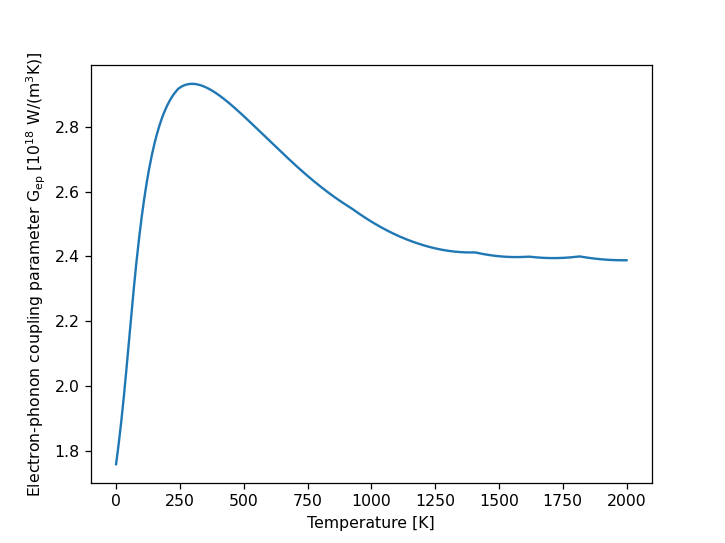

In [3]:
g = calculate_electron_phonon_coupling(temperatures,lattice_temperature,mu,e_dos,fermi_energy,eliashberg)

# convert from W/(unit cell K) to W/(m^3 K)
g = g/unit_cell_volume

# plot the result (optional)
plt.figure()
plt.plot(temperatures,g*1e-18)
plt.xlabel('Temperature [K]'), plt.ylabel('Electron-phonon coupling parameter G$_\mathrm{ep}$ [10$^{18}$ W/(m$^3$K)]')

# save the result as text file
np.savetxt('results/'+material+'_notSpinResolved_electronPhononCoupling.txt',np.transpose([temperatures,g]),fmt='%07.2f %e',\
    header='material: '+material+' \n'
           'electron-phonon coupling parameter G_ep '
           '(DFT calculation not spin resolved) \n'
           'temperature [K], g_ep [W/(m^3K)] ')


## Electron heat capacity


The electron heat capacity, $c_\mathrm{e}$, is the derivative of the electron energy ($E_\mathrm{e}$) with respect to the temperature:

\begin{equation}
    c_\mathrm{e}(T)=\left(\frac{\partial E_\mathrm{e}}{\partial T}\right)_V=\frac{d}{dT}\left[\int_{-\infty}^{\infty} g_\mathrm{e}(\epsilon) \frac{\epsilon}{\mathrm{exp}\left( \frac{\epsilon-\mu(T)}{k_\mathrm{B}T}\right)+1}d\epsilon\right].
    \label{eq:c_e}
\end{equation}

$g_\mathrm{e}$ is the electronic density of states and $\mu$ is the chemical potential. 

The equation corresponds to the electron heat capacity at constant volume. 


<IPython.core.display.Javascript object>


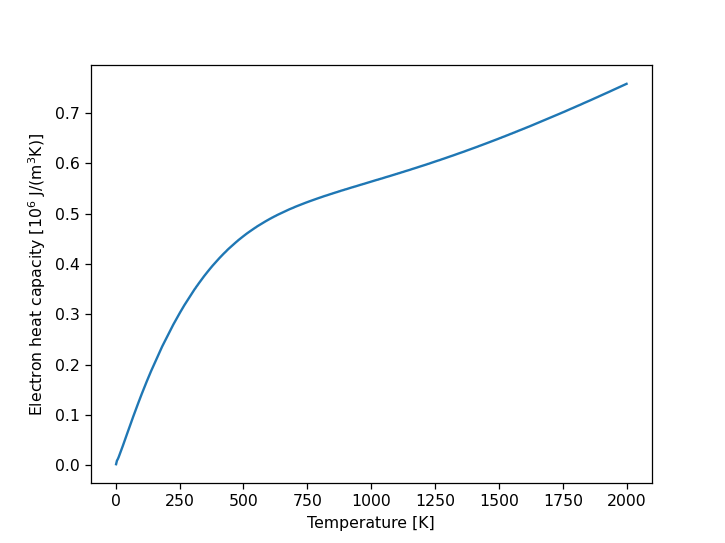

In [4]:
electron_heat_capacity = calculate_electron_heat_capacity(temperatures,mu,e_dos,fermi_energy)
# Due to the numerical differentiation, the temperature sampling changes. Therefore, the output has two colums 
# with the first column corresponding to the new temperature points.

# convert from J/(unit cell K) to J/(m^3 K)
electron_heat_capacity[:,1] = electron_heat_capacity[:,1]/unit_cell_volume

# plot the result (optional)
plt.figure()
plt.plot(electron_heat_capacity[:,0],electron_heat_capacity[:,1]*1e-6)
plt.xlabel('Temperature [K]'), plt.ylabel('Electron heat capacity [10$^6$ J/(m$^3$K)]')

# save the result as text file
np.savetxt('results/'+material+'_notSpinResolved_electronHeatCapacity.txt',electron_heat_capacity,fmt='%07.2f %e',\
    header='material: '+material+' \n'
           'electron heat capacity (DFT calculation not spin resolved) \n'
           'temperature [K], heat capacity [J/(m^3K)] ')



## Phonon heat capacity

The phonon heat capacity is calculated analogously to the electron heat capacity, with the difference that the Bose-Einstein distribution instead of the Fermi-Dirac distribution is required here:

\begin{equation}
    c_\mathrm{l}(T)=\left(\frac{\partial E_\mathrm{l}}{\partial T}\right)_V=\frac{d}{dT}\left[\int_{-\infty}^{\infty} g_\mathrm{l}(\epsilon) \frac{\epsilon}{\mathrm{exp}\left( \frac{\epsilon}{k_\mathrm{B}T}\right)-1}d\epsilon\right].
    \label{eq:c_l}
\end{equation}

$g_\mathrm{l}$ is the phonon density of states and $E_\mathrm{l}$ is the total energy in the phonon system.

Also here, the equation corresponds to the heat capacity at constant volume.

<IPython.core.display.Javascript object>


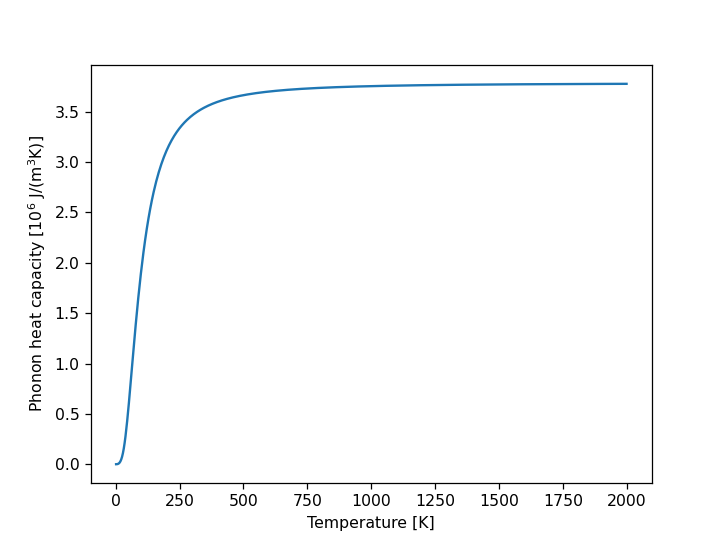

In [5]:
phonon_heat_capacity = calculate_phonon_heat_capacity(temperatures,v_dos)
# Due to the numerical differentiation, the temperature sampling changes. Therefore, the output has two colums 
# with the first column corresponding to the new temperature points.

# convert from J/(unit cell K) to J/(m^3 K)
phonon_heat_capacity[:,1] = phonon_heat_capacity[:,1]/unit_cell_volume

# plot the result (optional)
plt.figure()
plt.plot(phonon_heat_capacity[:,0],phonon_heat_capacity[:,1]*1e-6)
plt.xlabel('Temperature [K]'), plt.ylabel('Phonon heat capacity [10$^6$ J/(m$^3$K)]')

# save the result as text file
np.savetxt('results/'+material+'_notSpinResolved_phononHeatCapacity.txt',phonon_heat_capacity,fmt='%07.2f %e',\
    header='material: '+material+' \n'
           'phonon heat capacity (DFT calculation not spin resolved) \n'
           'temperature [K], heat capacity [J/(m^3K)] ')
